##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 2D spatial understanding with Gemini

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

This notebook introduces object detection and spatial understanding with the Gemini API like in the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) and demonstrated in the [Building with Gemini 2.0: Spatial understanding](https://www.youtube.com/watch?v=-XmoDzDMqj4) video.

You'll learn how to use Gemini the same way as in the demo and perform object detection like this:
<img src="https://storage.googleapis.com/generativeai-downloads/images/cupcakes_with_bbox.png" />

There are many examples, including object detection with

* simply overlaying information
* searching within an image
* translating and understanding things in multiple languages
* using Gemini thinking abilities

**Note**

There's no "magical prompt". Feel free to experiment with different ones. You can use the dropdown to see different samples, but you can also write your own prompts. Also, you can try uploading your own images.

----

## Setup

### Install SDK

In [2]:
%pip install -U -q "google-genai>=1.16.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.6/426.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.43.0, but you have google-auth 2.45.0 which is incompatible.


### Setup your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [3]:
from google.colab import userdata
import os

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key.

In [4]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Select and configure a model

Spatial understanding works best [Gemini 2.0 Flash model](https://ai.google.dev/gemini-api/docs/models/gemini-v2). It's even better with 2.5 models like `gemini-2.5-pro` but slightly slower as it's a [thinking](./Get_started_thinking.ipynb) model.

Some features, like segmentation, only works with 2.5 models.

The [Object detection](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/examples/Object_detection.ipynb) contains good examples of what previous models were able to do.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [5]:
MODEL_ID = "gemini-2.5-flash" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-2.5-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

### System instructions

 With the new SDK, the `system_instructions` and the `model` parameters must be passed in all `generate_content` calls, so let's save them to not have to type them all the time.

In [ ]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
"""

In [ ]:
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

The system instructions are mainly used to make the prompts shorter by not having to reapeat each time the format. They are also telling the model how to deal with similar objects which is a nice way to let it be creative.

The [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) is using a different strategy with no system instructions but a longer prompt. You can see their full prompts by clicking on the "show raw prompt" button on the right. There no optimal solution, experiment with diffrent strategies and find the one that suits your use-case the best.

It is also recommend to always disable the [thinking](./Get_started_thinking.ipynb), as so far it adds latency without improving the results.

### Import

Import all the necessary modules.

In [1]:
import google.generativeai as genai
from PIL import Image

import io
import os
import requests
from io import BytesIO

### Utils

Some scripts will be needed to draw the bounding boxes. Of course they are just examples and you are free to just write your own.

For example the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) uses HML to render the bounding boxes. You can find its code in the [Github repo](https://github.com/google-gemini/starter-applets/tree/main/spatial).

In [ ]:
# @title Parsing JSON output
def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [ ]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
!apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 3s (17.9 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


### Get example images

In [ ]:
# Load sample images
!wget https://storage.googleapis.com/generativeai-downloads/images/socks.jpg -O Socks.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/vegetables.jpg -O Vegetables.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Japanese_Bento.png -O Japanese_bento.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Cupcakes.jpg -O Cupcakes.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/origamis.jpg -O Origamis.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/fruits.jpg -O Fruits.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/cat.jpg -O Cat.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/pumpkins.jpg -O Pumpkins.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/breakfast.jpg -O Breakfast.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/bookshelf.jpg -O Bookshelf.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/spill.jpg -O Spill.jpg -q

## Overlaying Information

Let's start by loading an image, the origami one for example:

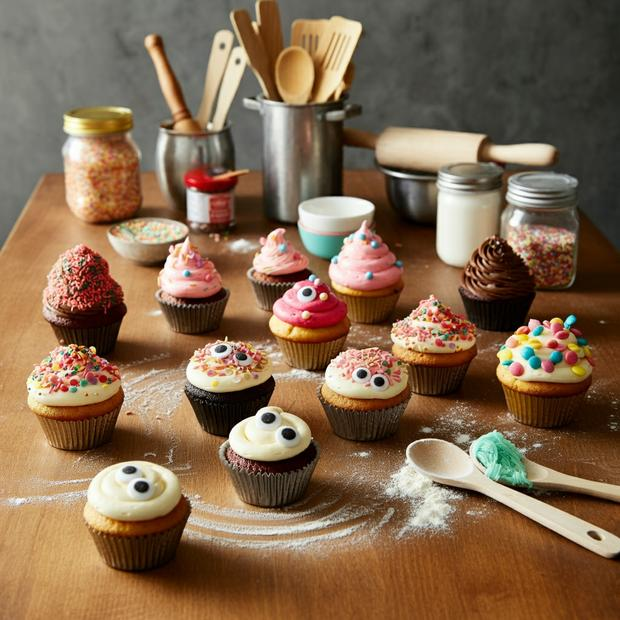

In [ ]:
image = "Cupcakes.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}

im = Image.open(image)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

Let's start with a simple prompt to find all items in the image.

To prevent the model from repeating itself, it is recommended to use a temperature over 0, in this case 0.5. Limiting the number of items (25 in the systemp instructions) is also a way to prevent the model from looping and to speed up the decoding of the bounding boxes. You can experiment with these parameters and find what works best for your use-case.

It is also recommend to always disable the [thinking](./Get_started_thinking.ipynb), as so far it adds latency without improving the results.

In [ ]:
prompt = "Detect the 2d bounding boxes of the cupcakes (with “label” as topping description”)"  # @param {type:"string"}

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Check output
print(response.text)

```json
[
  {"box_2d": [390, 64, 574, 203], "label": "red sprinkles"},
  {"box_2d": [382, 250, 537, 369], "label": "pink and blue sprinkles"},
  {"box_2d": [365, 397, 501, 509], "label": "pink frosting"},
  {"box_2d": [355, 529, 521, 650], "label": "pink frosting with blue balls"},
  {"box_2d": [384, 737, 535, 866], "label": "chocolate frosting"},
  {"box_2d": [443, 432, 595, 564], "label": "pink frosting with googly eyes"},
  {"box_2d": [477, 627, 638, 770], "label": "white frosting with colorful sprinkles"},
  {"box_2d": [556, 40, 726, 200], "label": "white frosting with colorful sprinkles"},
  {"box_2d": [510, 799, 690, 959], "label": "white frosting with colorful candies"},
  {"box_2d": [545, 295, 702, 444], "label": "white frosting with googly eyes"},
  {"box_2d": [559, 514, 712, 663], "label": "white frosting with googly eyes"},
  {"box_2d": [429, 597, 638, 770], "label": "white frosting with colorful sprinkles"},
  {"box_2d": [713, 271, 874, 497], "label": "white frosting with g

As you can see, even without any instructions about the format, Gemini is trained to always use this format with a label and the coordinates of the bounding box in a "box_2d" array.

Just be careful, the y coordinates are first, x ones afterwards contrary to common usage.

In [ ]:
plot_bounding_boxes(im, response.text)
im

Output hidden; open in https://colab.research.google.com to view.

## Search within an image

Let's complicate things and search within the image for specific objects.

```json
[
  {"box_2d": [46, 246, 385, 526], "label": "light blue sock with cat face on left"},
  {"box_2d": [233, 661, 650, 862], "label": "light blue and grey sock with cat face on right"}
]
```
(640, 482)


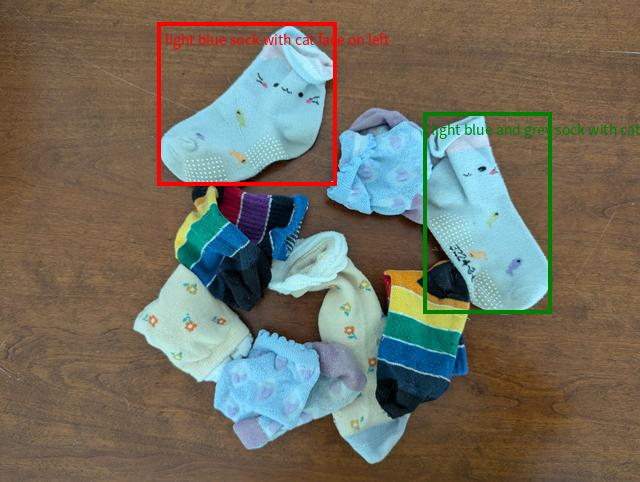

In [ ]:
image = "Socks.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Show me the positions of the socks with the face"  # @param ["Detect all rainbow socks", "Find all socks and label them with emojis ", "Show me the positions of the socks with the face","Find the sock that goes with the one at the top"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Check output
print(response.text)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

Try it with different images and prompts. Different samples are proposed but you can also write your own.

## Multilinguality

As Gemini is able to understand multiple languages, you can combine spatial reasoning with multilingual capabilities.

You can give it an image like this and prompt it to label each item with Japanese characters and English translation. The model reads the text and recognize the pictures from the image itself and translates them.

(640, 640)


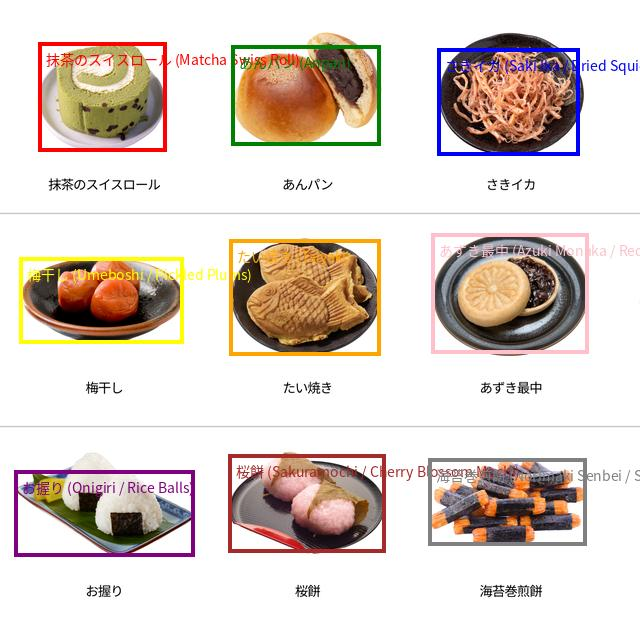

In [ ]:
image = "Japanese_bento.png" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Detect food, label them with Japanese characters + english translation."  # @param ["Detect food, label them with Japanese characters + english translation.", "Show me the vegan dishes","Explain what those dishes are with a 5 words description","Find the dishes with allergens and label them accordingly"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

## Use Gemini reasoning capabilities

The model can also reason based on the image, you can ask it about the positions of items, their utility, or, like in this example, to find the shadow of a speficic item.

(640, 482)


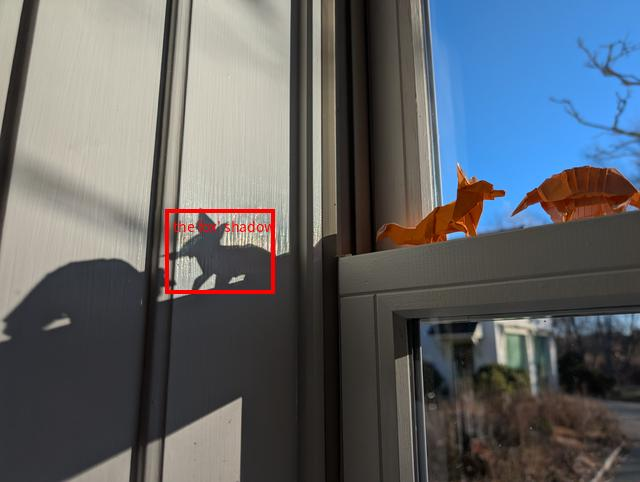

In [ ]:
image = "Origamis.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Draw a square around the fox' shadow"  # @param ["Find the two origami animals.", "Where are the origamis' shadows?","Draw a square around the fox' shadow"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

You can also use Gemini knowledge to enhanced the labels returned. In this example Gemini will give you advice on how to fix your little mistake.

As you can see this time, you're only resizing the image to 1024px as it helps the model getting the bigger picture and give you advice. There's no clear rule about when to do it, experiment and find what works the best for you.

(640, 480)


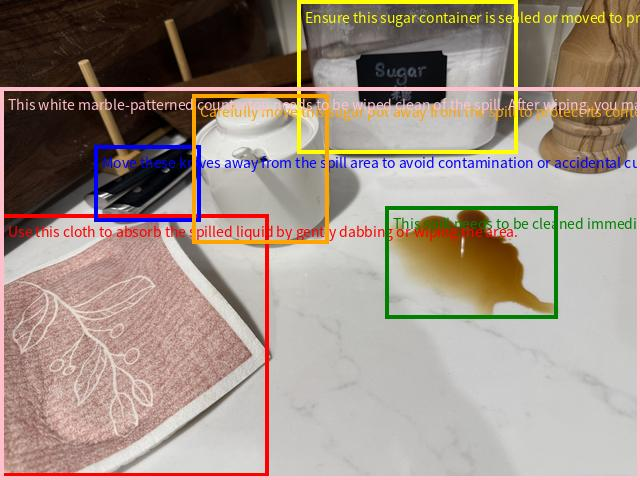

In [ ]:
image = "Spill.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Tell me how to clean my table with an explanation as label. Do not just label the items"  # @param ["Show me where my coffee was spilled.", "Tell me how to clean my table with an explanation as label. Do not just label the items","Draw a square around the fox' shadow"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

In [ ]:
response.text

'```json\n[\n  {"box_2d": [447, 0, 992, 420], "label": "Use this cloth to absorb the spilled liquid by gently dabbing or wiping the area."},\n  {"box_2d": [431, 603, 663, 871], "label": "This spill needs to be cleaned immediately to prevent staining the countertop."},\n  {"box_2d": [303, 147, 461, 314], "label": "Move these knives away from the spill area to avoid contamination or accidental cuts during cleaning."},\n  {"box_2d": [0, 465, 320, 808], "label": "Ensure this sugar container is sealed or moved to prevent it from getting wet or contaminated during cleaning."},\n  {"box_2d": [196, 301, 508, 514], "label": "Carefully move this sugar pot away from the spill to protect its contents and prevent it from being knocked over."},\n  {"box_2d": [182, 0, 998, 1000], "label": "This white marble-patterned countertop needs to be wiped clean of the spill. After wiping, you may want to use a damp cloth to remove any residue and then dry it thoroughly."}\n]\n```'

And if you check the previous examples, the [Japanese food](#scrollTo=tvVSSr7z3uN4) one in particular, multiple other prompt samples are provided to experiment with Gemini reasoning capabilities.

## Experimental: Segmentation

2.5 models are also able to segment the image and not only draw a bounding box but to also provide a mask of the contour of the items. It's especially useful if you are planning on editing images like in the [Virtual try-on](../examples/Virtual_Try_On.ipynb) example.

In [ ]:
# @title Segmentation Utils

import dataclasses
import numpy as np
import base64

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
  # bounding box pixel coordinates (not normalized)
  y0: int # in [0..height - 1]
  x0: int # in [0..width - 1]
  y1: int # in [0..height - 1]
  x1: int # in [0..width - 1]
  mask: np.array # [img_height, img_width] with values 0..255
  label: str

def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> list[SegmentationMask]:
  items = json.loads(parse_json(predicted_str))
  masks = []
  for item in items:
    raw_box = item["box_2d"]
    abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
    abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
    abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
    abs_x1 = int(item["box_2d"][3] / 1000 * img_width)
    if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
      print("Invalid bounding box", item["box_2d"])
      continue
    label = item["label"]
    png_str = item["mask"]
    if not png_str.startswith("data:image/png;base64,"):
      print("Invalid mask")
      continue
    png_str = png_str.removeprefix("data:image/png;base64,")
    png_str = base64.b64decode(png_str)
    mask = Image.open(io.BytesIO(png_str))
    bbox_height = abs_y1 - abs_y0
    bbox_width = abs_x1 - abs_x0
    if bbox_height < 1 or bbox_width < 1:
      print("Invalid bounding box")
      continue
    mask = mask.resize((bbox_width, bbox_height), resample=Image.Resampling.BILINEAR)
    np_mask = np.zeros((img_height, img_width), dtype=np.uint8)
    np_mask[abs_y0:abs_y1, abs_x0:abs_x1] = mask
    masks.append(SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, np_mask, label))
  return masks

def overlay_mask_on_img(
    img: Image,
    mask: np.ndarray,
    color: str,
    alpha: float = 0.7
) -> Image.Image:
    """
    Overlays a single mask onto a PIL Image using a named color.

    The mask image defines the area to be colored. Non-zero pixels in the
    mask image are considered part of the area to overlay.

    Args:
        img: The base PIL Image object.
        mask: A PIL Image object representing the mask.
              Should have the same height and width as the img.
              Modes '1' (binary) or 'L' (grayscale) are typical, where
              non-zero pixels indicate the masked area.
        color: A standard color name string (e.g., 'red', 'blue', 'yellow').
        alpha: The alpha transparency level for the overlay (0.0 fully
               transparent, 1.0 fully opaque). Default is 0.7 (70%).

    Returns:
        A new PIL Image object (in RGBA mode) with the mask overlaid.

    Raises:
        ValueError: If color name is invalid, mask dimensions mismatch img
                    dimensions, or alpha is outside the 0.0-1.0 range.
    """
    if not (0.0 <= alpha <= 1.0):
        raise ValueError("Alpha must be between 0.0 and 1.0")

    # Convert the color name string to an RGB tuple
    try:
        color_rgb: Tuple[int, int, int] = ImageColor.getrgb(color)
    except ValueError as e:
        # Re-raise with a more informative message if color name is invalid
        raise ValueError(f"Invalid color name '{color}'. Supported names are typically HTML/CSS color names. Error: {e}")

    # Prepare the base image for alpha compositing
    img_rgba = img.convert("RGBA")
    width, height = img_rgba.size

    # Create the colored overlay layer
    # Calculate the RGBA tuple for the overlay color
    alpha_int = int(alpha * 255)
    overlay_color_rgba = color_rgb + (alpha_int,)

    # Create an RGBA layer (all zeros = transparent black)
    colored_mask_layer_np = np.zeros((height, width, 4), dtype=np.uint8)

    # Mask has values between 0 and 255, threshold at 127 to get binary mask.
    mask_np_logical = mask > 127

    # Apply the overlay color RGBA tuple where the mask is True
    colored_mask_layer_np[mask_np_logical] = overlay_color_rgba

    # Convert the NumPy layer back to a PIL Image
    colored_mask_layer_pil = Image.fromarray(colored_mask_layer_np, 'RGBA')

    # Composite the colored mask layer onto the base image
    result_img = Image.alpha_composite(img_rgba, colored_mask_layer_pil)

    return result_img

def plot_segmentation_masks(img: Image, segmentation_masks: list[SegmentationMask]):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img: The PIL.Image.
        segmentation_masks: A string encoding as JSON a list of segmentation masks containing the name of the object,
         their positions in normalized [y1 x1 y2 x2] format, and the png encoded segmentation mask.
    """
    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors
    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Do this in 3 passes to make sure the boxes and text are always visible.

    # Overlay the mask
    for i, mask in enumerate(segmentation_masks):
      color = colors[i % len(colors)]
      img = overlay_mask_on_img(img, mask.mask, color)

    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Draw the bounding boxes
    for i, mask in enumerate(segmentation_masks):
      color = colors[i % len(colors)]
      draw.rectangle(
          ((mask.x0, mask.y0), (mask.x1, mask.y1)), outline=color, width=4
      )

    # Draw the text labels
    for i, mask in enumerate(segmentation_masks):
      color = colors[i % len(colors)]
      if mask.label != "":
        draw.text((mask.x0 + 8, mask.y0 - 20), mask.label, fill=color, font=font)
    return img

```json
[
  {"box_2d": [168, 97, 360, 228], "mask": "", "label": "glass jar with sprinkles"},
  {"box_2d": [276, 804, 467, 936], "mask": "", "label": "glass jar with sprinkles"},
  {"box_2d": [260, 699, 431, 810], "mask": "", "label": "glass jar with milk"},
  {"box_2d": [272, 296, 376, 396], "mask": "", "label": "glass body of red jar"},
  {"box_2d": [272, 296, 376, 396], "mask": "", "label": "metal lid of red jar"},
  {"box_2d": [267, 617, 368, 706], "mask": "", "label": "small metal bowl"},
  {"box_2d": [147, 391, 362, 584], "mask": "", "label": "large metal pot"},
  {"box_2d": [190, 252, 340, 381], "mask": "", "label": "small metal container"},
  {"box_2d": [203, 552, 278, 896], "mask": "", "label": "wooden rolling pin"},
  {"box_2d": [57, 233, 220, 332], "mask": "", "label": "wooden utensils in small container"},
  {"box_2d": [0, 369, 167, 586], "mask": "", "label": "wooden utensils in large pot"},
  {"box_2d": [508, 798, 691, 960], "mask": "", "label": "metal lid of sprinkle jar"
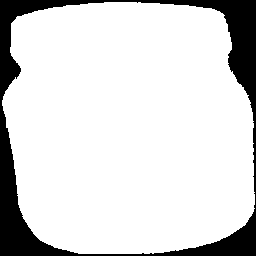
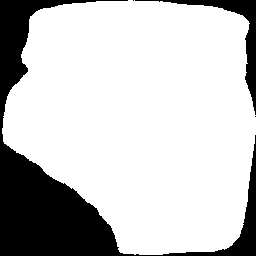
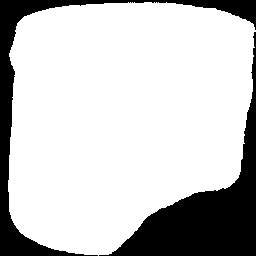
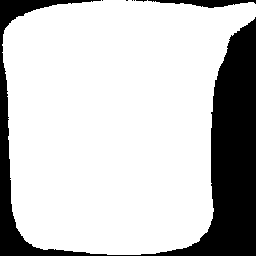
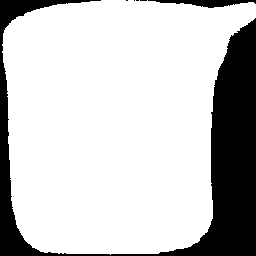
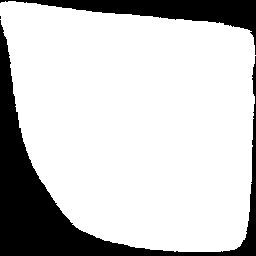
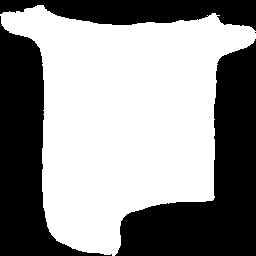
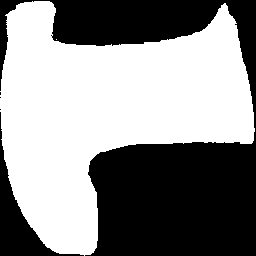
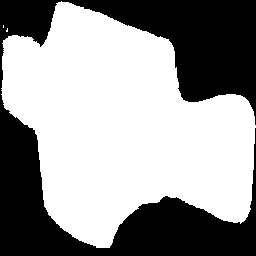
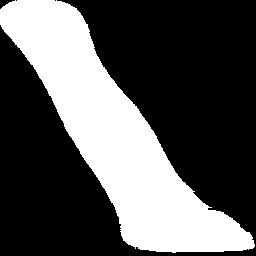
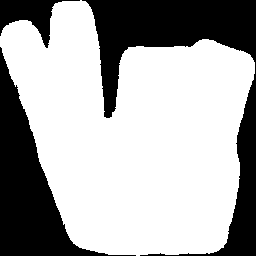
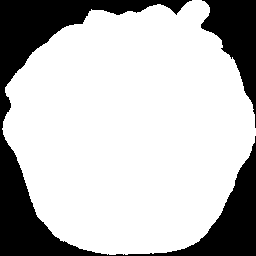
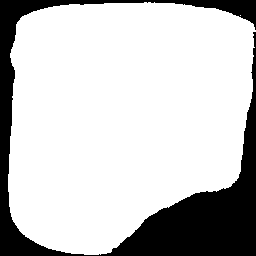
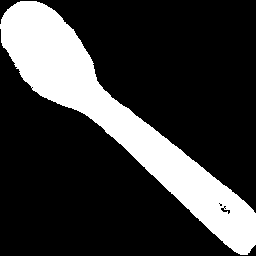
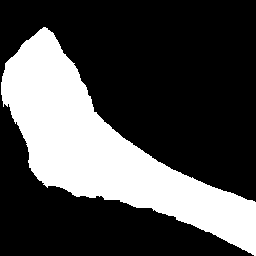

In [ ]:
image = "Cupcakes.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Give the segmentation masks for the metal, wooden and glass small items (ignore the table). Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key \"box_2d\", the segmentation mask in key \"mask\", and the text label in the key \"label\". Use descriptive labels."  # @param {type:"string"}

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find segmentation masks
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Check output
print(response.text)

The model predicts a JSON list, where each item represents a segmentation mask. Each item has a bounding box ("`box_2d`") in the format `[y0, x0, y1, x1]` with normalized coordinates between 0 and 1000, a label ("`label`") that identifies the object, and lastly the segmentation mask inside the bounding box, as base64 encoded png.

To use the mask, first you need to do base64 decoding, and then loading this string as a png. This will give you a probability map with values between 0 and 255. The mask needs to be resized to match the bounding box dimensions, then you can apply your confidence threshold, e.g. binarizing at 127 for the midpoint. Finally, pad the mask into an array of the size of the full image.

All these steps are done by the the `parse_segmentation_masks` function provided earlier.

Ultimately, use the `plot_segmentation_masks` function to visualize the decoded masks by overlaying it on the image.

In [ ]:
segmentation_masks = parse_segmentation_masks(response.text, img_height=im.size[1], img_width=im.size[0])

In [ ]:
plot_segmentation_masks(im, segmentation_masks)

Output hidden; open in https://colab.research.google.com to view.

# 新段落

>>> [DEBUG] 开始处理...
>>> [DEBUG] 尺度校准: 配件宽约 1.54 个格子, 高约 2.05 个格子
>>> [DEBUG] 网格已生成，共 8x8 个区域。


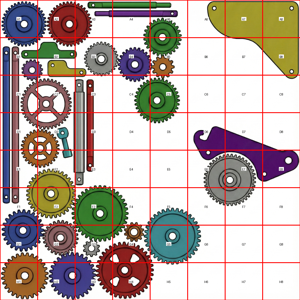


>>> [DEBUG] 请求 gemini-2.5-flash 预测可放置网格...
>>> [DEBUG] AI 原始响应:
{"suggested_regions": ["B5", "B6", "B7", "G6", "G7"], "reasoning": "The part is 1.5 grid cells wide and 2.0 grid cells high. To accommodate this, a 2x2 block of empty grid cells is required, with the suggested region being the top-left cell of this block. The identified regions (B5, B6, B7, G6, G7) are the top-left corners of such 2x2 empty blocks. Other seemingly empty cells were rejected because the required 2x2 area extended into an occupied cell (e.g., D6, E6, F6, G5) or off the sheet."}

>>> [AI Reasoning]: The part is 1.5 grid cells wide and 2.0 grid cells high. To accommodate this, a 2x2 block of empty grid cells is required, with the suggested region being the top-left cell of this block. The identified regions (B5, B6, B7, G6, G7) are the top-left corners of such 2x2 empty blocks. Other seemingly empty cells were rejected because the required 2x2 area extended into an occupied cell (e.g., D6, E6, F6, G5) or off t

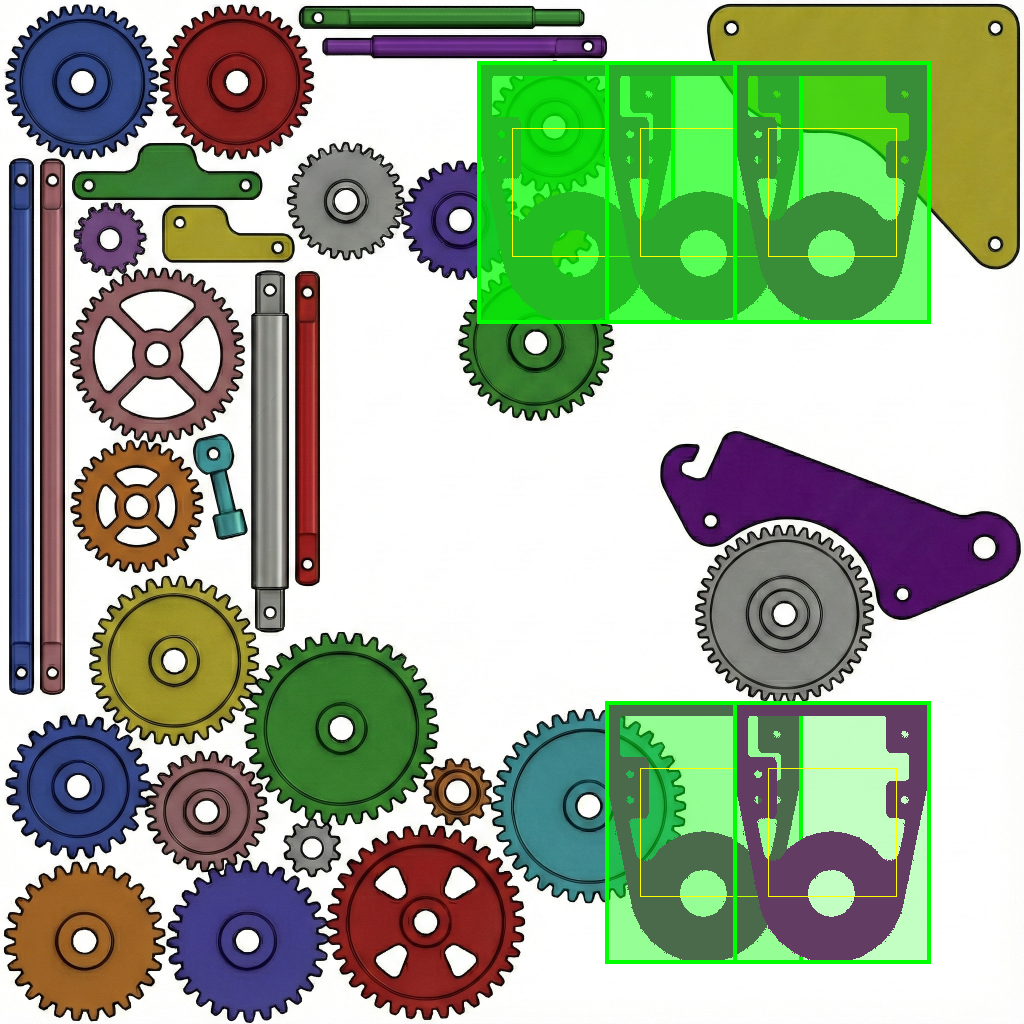

In [12]:
import base64
import json
import numpy as np
import string
from PIL import Image, ImageDraw, ImageOps, ImageFont
from google.genai import types
from IPython.display import display

# ==========================================
# Client 初始化 (保持原样，根据你的环境配置)
# ==========================================
# import os
# import google.generativeai as genai
# os.environ["GOOGLE_API_KEY"] = "YOUR_KEY"
# client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])
# model_name = "gemini-2.5-flash"

# ==========================================
# 1. 图像处理工具函数 (保留原有逻辑)
# ==========================================

def make_white_transparent(image, threshold=240):
    img = image.convert("RGBA")
    data = np.array(img)
    r, g, b, a = data.T
    white_areas = (r >= threshold) & (g >= threshold) & (b >= threshold)
    data[..., 3][white_areas.T] = 0
    return Image.fromarray(data)

def crop_transparent_borders(image):
    img = image.convert("RGBA")
    alpha = img.split()[-1]
    bbox = alpha.getbbox()
    if bbox:
        return img.crop(bbox)
    return img

# ==========================================
# 2. 【新增】网格绘制与映射工具
# ==========================================

def draw_grid_with_labels(image, rows=10, cols=10):
    """
    在图片上绘制网格和坐标标签 (A1, B2...)
    返回:
    1. 绘制了网格的图片 (用于传给 Gemini)
    2. grid_map (字典): {'A1': [x, y, w, h], ...} 用于将标签转回坐标
    """
    img_draw = image.copy().convert("RGB")
    draw = ImageDraw.Draw(img_draw)
    w, h = img_draw.size

    step_x = w / cols
    step_y = h / rows

    grid_map = {}

    # 定义字体 (尝试加载字体，如果失败使用默认)
    try:
        # 字号根据图片大小动态调整，大约是格子高度的1/3
        font_size = int(min(step_x, step_y) * 0.4)
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    # 生成行标 (A, B, C...) 和 列标 (1, 2, 3...)
    row_labels = list(string.ascii_uppercase)[:rows] # ['A', 'B', ...]

    for r in range(rows):
        for c in range(cols):
            # 计算当前格子的坐标
            x0 = c * step_x
            y0 = r * step_y
            x1 = x0 + step_x
            y1 = y0 + step_y

            # 生成标签 ID (例如 "A1")
            label_id = f"{row_labels[r]}{c+1}"

            # 存入字典，供后续查找
            grid_map[label_id] = [x0, y0, x1, y1]

            # --- 绘图 ---
            # 1. 画格子框 (半透明红色或显眼的颜色)
            draw.rectangle([x0, y0, x1, y1], outline="red", width=2)

            # 2. 画标签文字 (居中)
            # 为了让文字清楚，先画个白色底色块
            text_bbox = draw.textbbox((0, 0), label_id, font=font)
            text_w = text_bbox[2] - text_bbox[0]
            text_h = text_bbox[3] - text_bbox[1]

            text_x = x0 + (step_x - text_w) / 2
            text_y = y0 + (step_y - text_h) / 2

            # 文字背景 (避免背景杂乱看不清字)
            draw.rectangle([text_x-2, text_y-2, text_x+text_w+2, text_y+text_h+2], fill="white")
            draw.text((text_x, text_y), label_id, fill="black", font=font)

    return img_draw, grid_map

# ==========================================
# 3. 主流程
# ==========================================

part_image_path = 'part_2.png'
sheet_image_path = 'sheet_3.png'

print(">>> [DEBUG] 开始处理...")

try:
    # 加载图片
    sheet_img_original = Image.open(sheet_image_path).convert("RGB") # 保留一份原始的
    raw_part = Image.open(part_image_path)

    # 零件预处理 (去白底、裁剪)
    part_img_transparent = make_white_transparent(raw_part)
    part_img = crop_transparent_borders(part_img_transparent)

    sheet_w, sheet_h = sheet_img_original.size
    part_w, part_h = part_img.size

    # -------------------------------------------------
    # 【新增步骤】为板材图增加网格
    # -------------------------------------------------
    GRID_ROWS = 8  # 可以根据板材复杂度调整
    GRID_COLS = 8

    sheet_img_gridded, grid_lookup = draw_grid_with_labels(sheet_img_original, rows=GRID_ROWS, cols=GRID_COLS)

    # 1. 获取单个网格的像素尺寸
    # sheet_w 是板材总宽, GRID_COLS 是列数 (比如 8)
    grid_pixel_width = sheet_w / GRID_COLS
    grid_pixel_height = sheet_h / GRID_ROWS

    # 2. 计算配件占用了多少个网格 (关键步骤！)
    part_scale_x = part_w / grid_pixel_width
    part_scale_y = part_h / grid_pixel_height

    print(f">>> [DEBUG] 尺度校准: 配件宽约 {part_scale_x:.2f} 个格子, 高约 {part_scale_y:.2f} 个格子")

    print(f">>> [DEBUG] 网格已生成，共 {GRID_ROWS}x{GRID_COLS} 个区域。")
    # 可选：显示带网格的图看看效果
    display(sheet_img_gridded.resize((300, 300)))

    # ==========================================
    # 4. Prompt 与 Schema (改为分类任务)
    # ==========================================

    # 修改 Schema：只要求返回网格 ID 的列表
    response_schema = {
        "type": "OBJECT",
        "properties": {
            "suggested_regions": {
                "type": "ARRAY",
                "description": "List of grid cell IDs (e.g., 'A1', 'B3') representing empty space suitable for the part.",
                "items": {"type": "STRING"}
            },
            "reasoning": {
                "type": "STRING",
                "description": "Brief explanation of why these grids were chosen."
            }
        },
        "required": ["suggested_regions", "reasoning"]
    }

    system_inst = """
    You are an expert nesting engine assistant.
    Your goal is to identify **empty regions** on a material sheet where a new part can be placed.

    **INPUTS:**
    1. Image 1: The Sheet Material (Overlayed with a Red Grid and Labels like A1, B2...).
    2. Image 2: The Part to be placed.

    **TASK:**
    1. Analyze the Sheet Image. Identify grid cells that are mostly **WHITE (Empty)**.
    2. Ignore grid cells that contain colored parts (Red/Yellow gears).
    3. Estimate the size of the Part relative to the grid squares.
    4. Select the grid cells that serve as the best "Starting Point" or "Center" for placing the part.
    5. Return the IDs of these grid cells (e.g., "C4", "D5").
    """

    # 3. 将这个精确的比例写入 Prompt
    # 这样 Gemini 不需要猜，它会去寻找 "宽 1.2 格，高 2.5 格" 的空位
    prompt = f"""
    Look at the Grid on Image 1 (The Sheet).
    I need to place the Part shown in Image 2.

    **CRITICAL SCALE INFO:**
    Based on pixel measurements:
    - The Part's WIDTH is approximately **{part_scale_x:.1f} grid cells**.
    - The Part's HEIGHT is approximately **{part_scale_y:.1f} grid cells**.

    **TASK:**
    Identify grid cells (e.g., "B7") that are the top-left corner of an empty area large enough to fit this size ({part_scale_x:.1f} x {part_scale_y:.1f} grids).
    Return the Grid IDs.
    """

    # ==========================================
    # 5. API 调用
    # ==========================================
    print(f"\n>>> [DEBUG] 请求 {MODEL_ID} 预测可放置网格...")

    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[prompt, sheet_img_gridded, part_img], # 注意：这里传入的是带网格的图
        config=types.GenerateContentConfig(
            system_instruction=system_inst,
            temperature=0.1, # 分类任务温度要低，保证准确
            response_mime_type="application/json",
            response_schema=response_schema
        )
    )

    print(">>> [DEBUG] AI 原始响应:")
    print(response.text)

    result = json.loads(response.text)

    # ==========================================
    # 6. 后处理与可视化 (网格 -> 区域)
    # ==========================================

    suggested_ids = result.get("suggested_regions", [])
    reasoning = result.get("reasoning", "")

    print(f"\n>>> [AI Reasoning]: {reasoning}")

    if suggested_ids:
        # 在原始图（无网格）上把 AI 推荐的区域画出来
        final_visual = sheet_img_original.copy().convert("RGBA")
        draw = ImageDraw.Draw(final_visual)

        # 半透明绿色图层用于高亮
        highlight_layer = Image.new("RGBA", final_visual.size, (0, 0, 0, 0))
        draw_highlight = ImageDraw.Draw(highlight_layer)

        print(f">>> [RESULT] AI 推荐网格: {suggested_ids}")

        # ... 之前的代码 ...
        for grid_id in suggested_ids:
            if grid_id in grid_lookup:
                # 1. 获取网格的物理坐标 (Anchor)
                grid_coords = grid_lookup[grid_id] # [gx0, gy0, gx1, gy1]

                # 2. 计算网格中心点
                grid_cx = (grid_coords[0] + grid_coords[2]) / 2
                grid_cy = (grid_coords[1] + grid_coords[3]) / 2

                # 3. 【核心修改】基于零件真实尺寸计算新的包围盒
                # 假设我们将零件的中心对齐到网格的中心
                real_x0 = grid_cx - (part_w / 2)
                real_y0 = grid_cy - (part_h / 2)
                real_x1 = real_x0 + part_w
                real_y1 = real_y0 + part_h

                # 4. 边界检查 (防止画出画布外)
                real_x0 = max(0, real_x0)
                real_y0 = max(0, real_y0)
                real_x1 = min(sheet_w, real_x1)
                real_y1 = min(sheet_h, real_y1)

                real_box = [real_x0, real_y0, real_x1, real_y1]

                # --- 绘图 ---
                # A. 画出零件的“真实需求空间” (绿色框，现在能包裹住零件了)
                draw_highlight.rectangle(real_box, fill=(0, 255, 0, 60), outline="#00FF00", width=4)

                # B. 还是画一下原始网格，作为 Reference (黄色细线)
                draw_highlight.rectangle(grid_coords, outline="yellow", width=1)

                # C. 粘贴零件预览
                paste_x = int(real_x0)
                paste_y = int(real_y0)

                # 叠加零件影子 (紫色) 表示这是 AI 建议的大致位置
                part_shadow = ImageOps.colorize(part_img.convert("L"), black="purple", white="purple")
                part_mask = part_img.split()[3]

                # 混合粘贴
                layer_patch = Image.new("RGBA", final_visual.size, (0,0,0,0))
                layer_patch.paste(part_shadow, (paste_x, paste_y), mask=part_mask)
                # 设置透明度
                final_visual = Image.alpha_composite(final_visual, layer_patch)
                # 合并高亮层
                final_visual = Image.alpha_composite(final_visual, highlight_layer)

        display(final_visual)

    else:
        print(">>> [WARN] AI 没有返回任何推荐区域。")

except Exception as e:
    import traceback
    traceback.print_exc()

## Preliminary capabilities: pointing and 3D boxes

Pointing and 3D bounding boxes are experimental model capabilities. Check this [other notebook](../examples/Spatial_understanding_3d.ipynb) to get a sneak peek on those upcoming capabilities.

<a href="../examples/Spatial_understanding_3d.ipynb"><img src="https://storage.googleapis.com/generativeai-downloads/images/box_3d.png" height="400"/></a>

## What's next?

For a more end-to-end example, the code from the [AI Studio Spatial understanding example](https://aistudio.google.com/starter-apps/spatial)  is available on [Github](https://github.com/google-gemini/starter-applets/tree/main/spatial).

You'll also find multiple other examples of Gemini apabilities in the [quickstart folder](https://github.com/google-gemini/cookbook/tree/main/quickstarts/), in particular the [Live API](./Get_started_LiveAPI.ipynb) and the [video understanding](./Video_understanding.ipynb) one.

Related to image recognition and reasoning, [Market a jet backpack](../examples/Market_a_Jet_Backpack.ipynb) and [Guess the shape](../examples/Guess_the_shape.ipynb) examples are worth checking to continue your Gemini API discovery (Note: these examples still use the old SDK). And of course the [pointing and 3d boxes](../examples/Spatial_understanding_3d.ipynb) example referenced earlier.